# Simulate LSST light curves and recover.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import rubin_rotation as rr
import starspot as ss
import exoplanet as xo
import time as tm
from tqdm import trange

import fastprogress as fp

import warnings
warnings.filterwarnings('ignore')

plotpar = {'axes.labelsize': 30,
                  'font.size': 22,
                  'legend.fontsize': 15,
                  'xtick.labelsize': 30,
                  'ytick.labelsize': 30,
                  'text.usetex': True}
plt.rcParams.update(plotpar)

Simulate a light curve

In [2]:
def sim_lc(prot, err, Nvisits=80, tspan=1, seed=42, tau_range=(1, 3)):

    Nvisits = 80
    np.random.seed(42)

    time = rr.generate_visits(Nvisits=Nvisits, tspan=1)

    sin2incl = np.random.uniform(np.sin(0)**2, np.sin(np.pi/2)**2)
    incl = np.arcsin(sin2incl**.5)
    tau = np.exp(np.random.uniform(np.log(tau_range[0]*prot), np.log(tau_range[1]*prot)))

    # Get LC
    res0, res1 = rr.mklc(time, incl=incl, tau=tau, p=prot)
    nspot, ff, amp_err = res0
    _, area_tot, dF_tot, dF_tot0 = res1
    pure_flux = dF_tot0 / np.median(dF_tot0) - 1

    flux = pure_flux + np.random.randn(Nvisits) * err
    flux_err = np.ones_like(flux)*err
    
    return time, flux, pure_flux, flux_err

<ErrorbarContainer object of 3 artists>

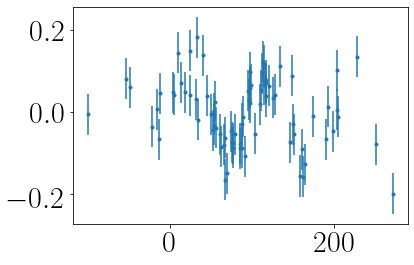

In [3]:
time, flux, pure_flux, flux_err = sim_lc(100, .05)
plt.errorbar(time, flux, flux_err, fmt=".")

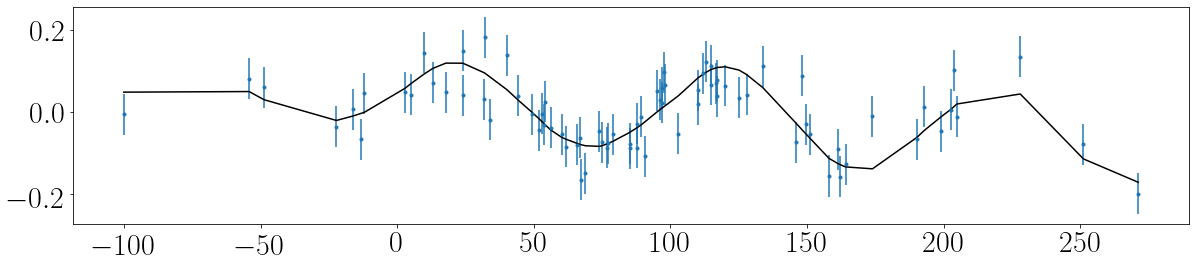

In [4]:
plt.figure(figsize=(20, 4))
plt.errorbar(time, flux, flux_err, fmt=".")
plt.plot(time, pure_flux, color="k")

98.30061817875239


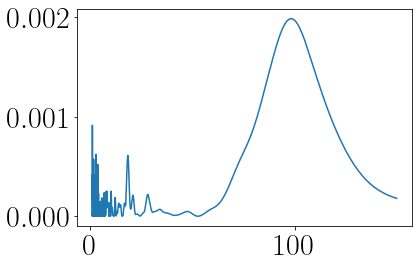

In [5]:
results = xo.estimators.lomb_scargle_estimator(time, flux, max_peaks=1, min_period=1.0, max_period=150.0,
                                               samples_per_peak=50)

peak = results["peaks"][0]
freq, power = results["periodogram"]
plt.plot(1./freq, power)
print(peak["period"])

In [6]:
Star = rr.Star(time, flux, flux_err, init_period=100)
start = tm.time()
map_soln, model = Star.singleband_gp(lower=1, upper=150)
end = tm.time()
print(end - start)

optimizing logp for variables: [mix, logdeltaQ, logQ0, logperiod, logamp, logw0, logSw4, logs2, mean]



12.038360834121704


message: Optimization terminated successfully.
logp: 45.688154800180406 -> 87.74656908448918


In [7]:
# # Star.mcmc()
# with model:
#     trace = xo.sample(tune=500, draws=1000, start=map_soln, target_accept=0.95)

In [8]:
# period_samples = trace["period"]
# bins = np.linspace(20, 45, 40)
# plt.hist(period_samples, bins, histtype="step", color="k")
# plt.yticks([])
# plt.xlim(bins.min(), bins.max())
# plt.xlabel("rotation period [days]")
# plt.ylabel("posterior density");

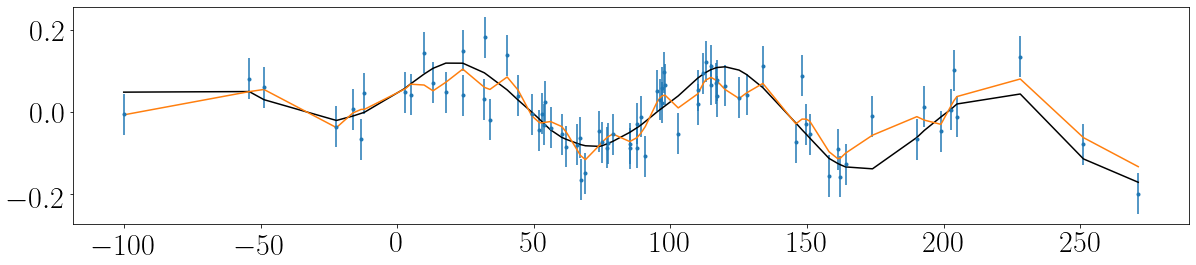

In [9]:
plt.figure(figsize=(20, 4))
plt.errorbar(time, flux, flux_err, fmt=".")
plt.plot(time, pure_flux, color="k");
plt.plot(time, map_soln["pred"] + map_soln["mean"], label="model");

In [10]:
nstars = 5000
prots = np.random.uniform(1, 150, nstars)
ls_prots, gp_prots, powr = [np.zeros(nstars) for i in range(3)]

for i in fp.progress_bar(range(nstars)):
    time, flux, pure_flux, flux_err = sim_lc(prots[i], .05)
    results = xo.estimators.lomb_scargle_estimator(time, flux, max_peaks=1, min_period=3.0, max_period=150.0,
                                                   samples_per_peak=50)

    peak = results["peaks"][0]
    powr[i] = peak["log_power"]
    freq, power = results["periodogram"]
    
#     map_soln = rr.singleband_gp(time, flux, flux_err, peak, lower=1, upper=50)

#     print("true period = ", prots[i])
#     print("ls period = ", peak["period"])
#     print("gp period = ", map_soln["period"])

#     plt.plot(1./freq, power)
#     plt.show()
    
#     plt.figure(figsize=(20, 4))
#     plt.errorbar(time, flux, flux_err, fmt=".")
#     plt.plot(time, pure_flux, color="k")
#     plt.plot(time, map_soln["pred"] + map_soln["mean"], label="model")
#     plt.show()
    
    ls_prots[i] = peak["period"]
#     gp_prots[i] = map_soln["period"]

10.040000000000001


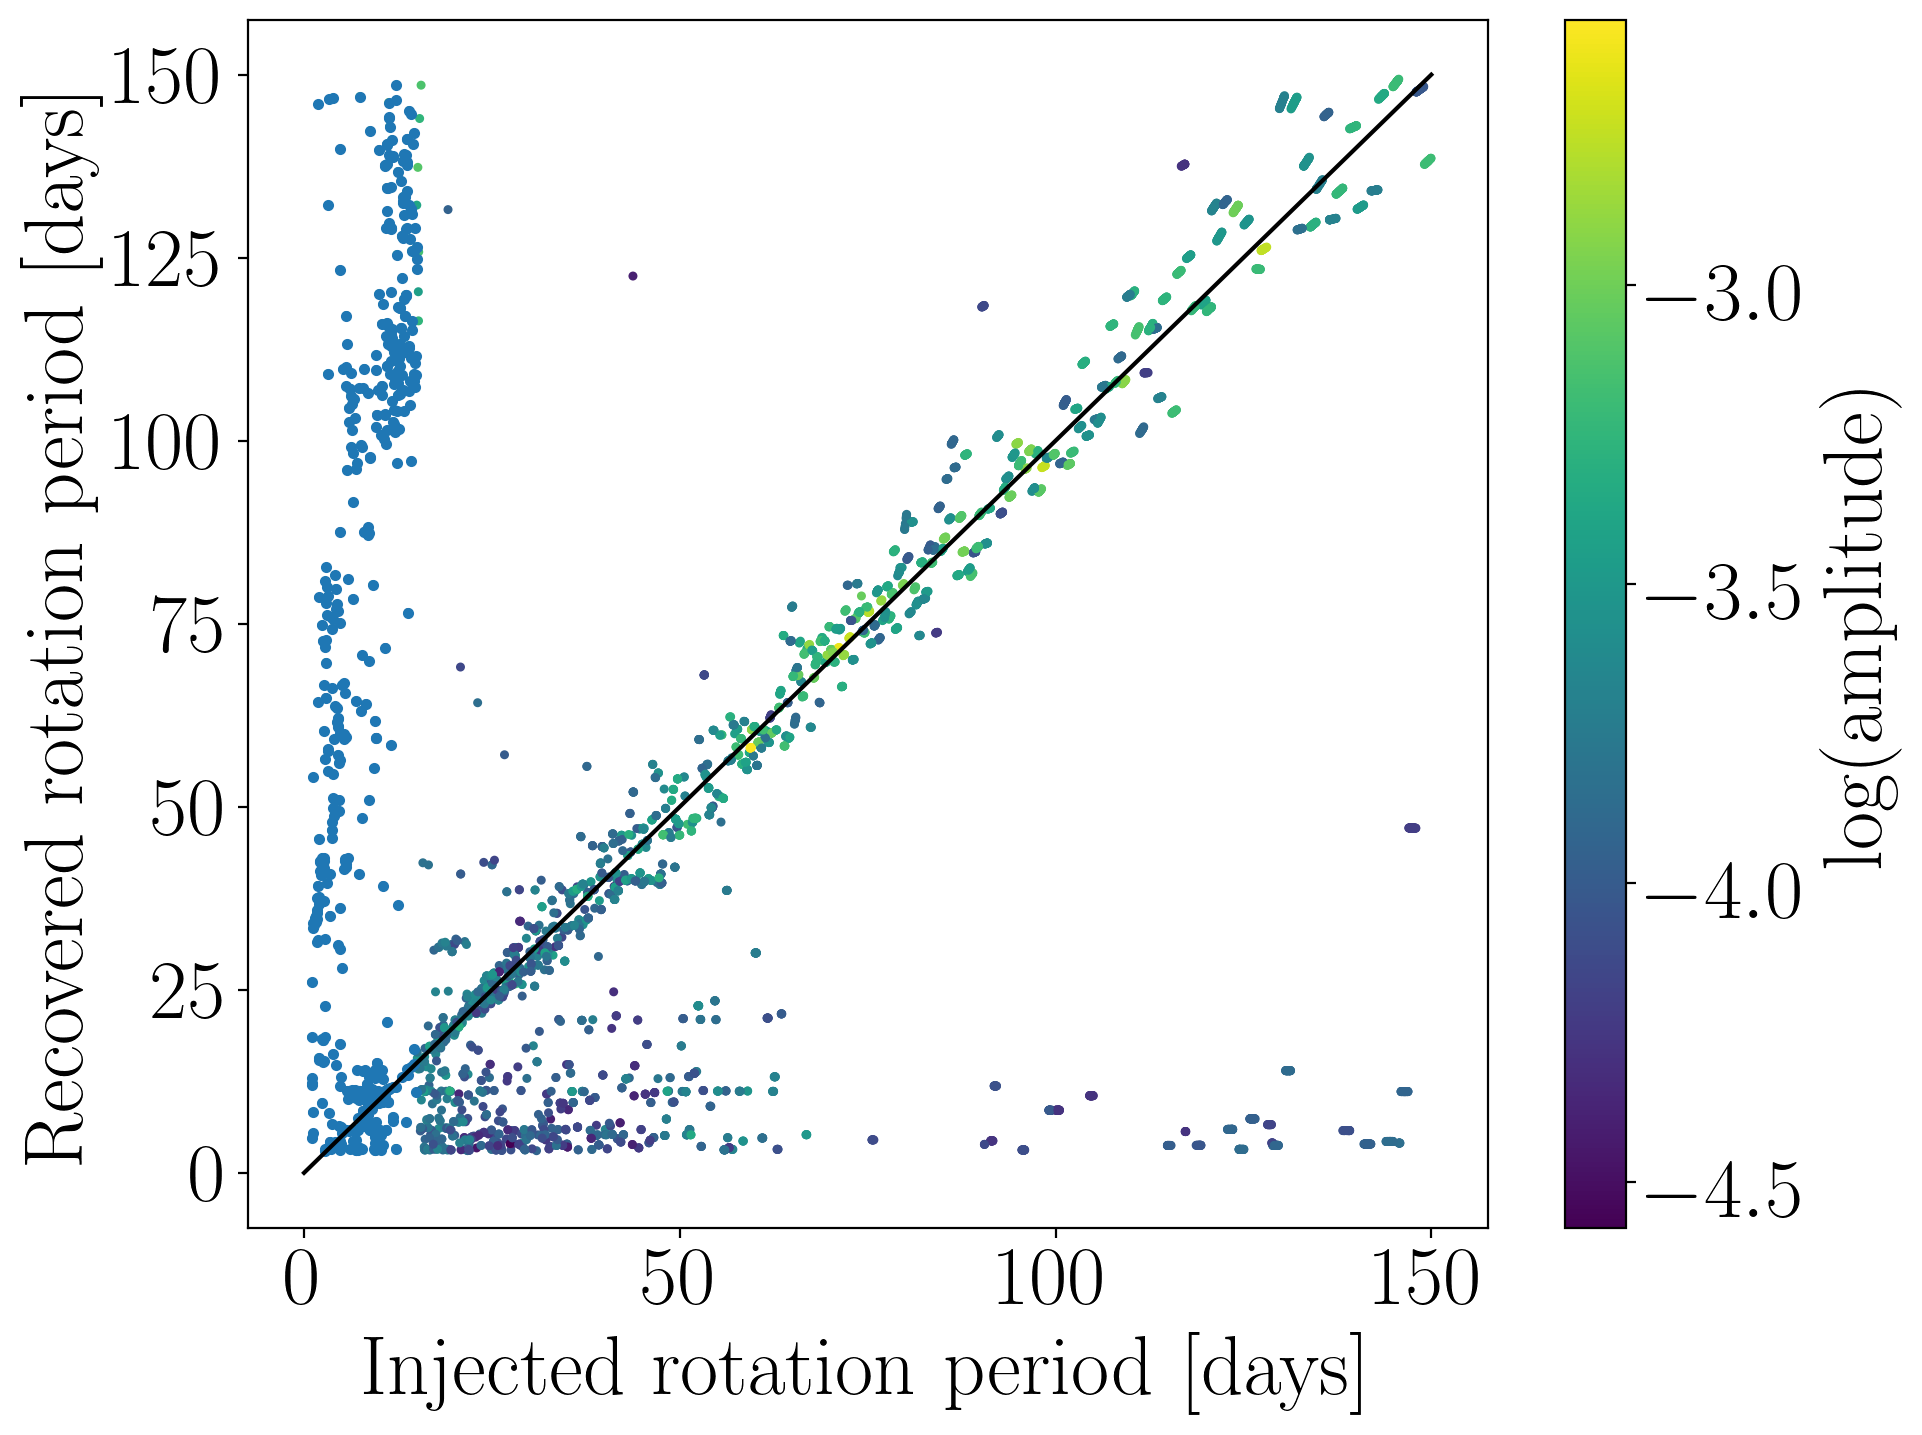

In [21]:
plt.figure(figsize=(10, 8), dpi=200)
m = powr/2 > -10 # -3.8
plt.scatter(prots[m], ls_prots[m], c=powr[m]/2, s=5)
m = prots < 15
plt.plot(prots[m], ls_prots[m], ".")
print(len(prots[m])/5000.*100)
plt.colorbar(label="$\mathrm{log(amplitude)}$")
# plt.plot(prots, gp_prots, ".")
xs = np.linspace(0, 150, 150)
plt.plot(xs, xs, "k")
plt.xlabel("$\mathrm{Injected~rotation~period~[days]}$");
plt.ylabel("$\mathrm{Recovered~rotation~period~[days]}$");
# plt.savefig("injection_recovery")
# plt.savefig("injection_recovery.pdf")

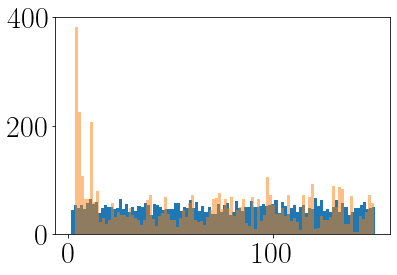

In [17]:
plt.hist(prots, 100);
plt.hist(ls_prots, 100, alpha=.5);

In [27]:
print(sum(ls_prots < 20)/np.float(nstars))
print(sum((prots < 15) & (ls_prots > 20))/np.float(nstars))
sum((prots < 15) & (ls_prots > 3))

0.872
0.011


79